## Assignment 2

#### Part 1. Breast Cancer Wisconsin Dataset

Here, we train a few decision tree classifiers on the Breast Cancer dataset and compare their performances.

In [263]:
import sys
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import load_breast_cancer, load_iris
import seaborn as sns

In [265]:
# Load the dataset
bc = load_breast_cancer()
bc_X, bc_y = load_breast_cancer(return_X_y=True, as_frame=True)
print("The format (shape) of feature matrix X is {} and class vector has {} elements".format(bc_X.shape, bc_y.shape))

The format (shape) of feature matrix X is (569, 30) and class vector has (569,) elements


Investigate whether some features can be dropped through suitable visualisation of the data. For instance, if 2 features have a linear relationship, then it would be sufficient to keep only one of these features.

Therefore, we can assess that the classification task later on should not be too difficult.

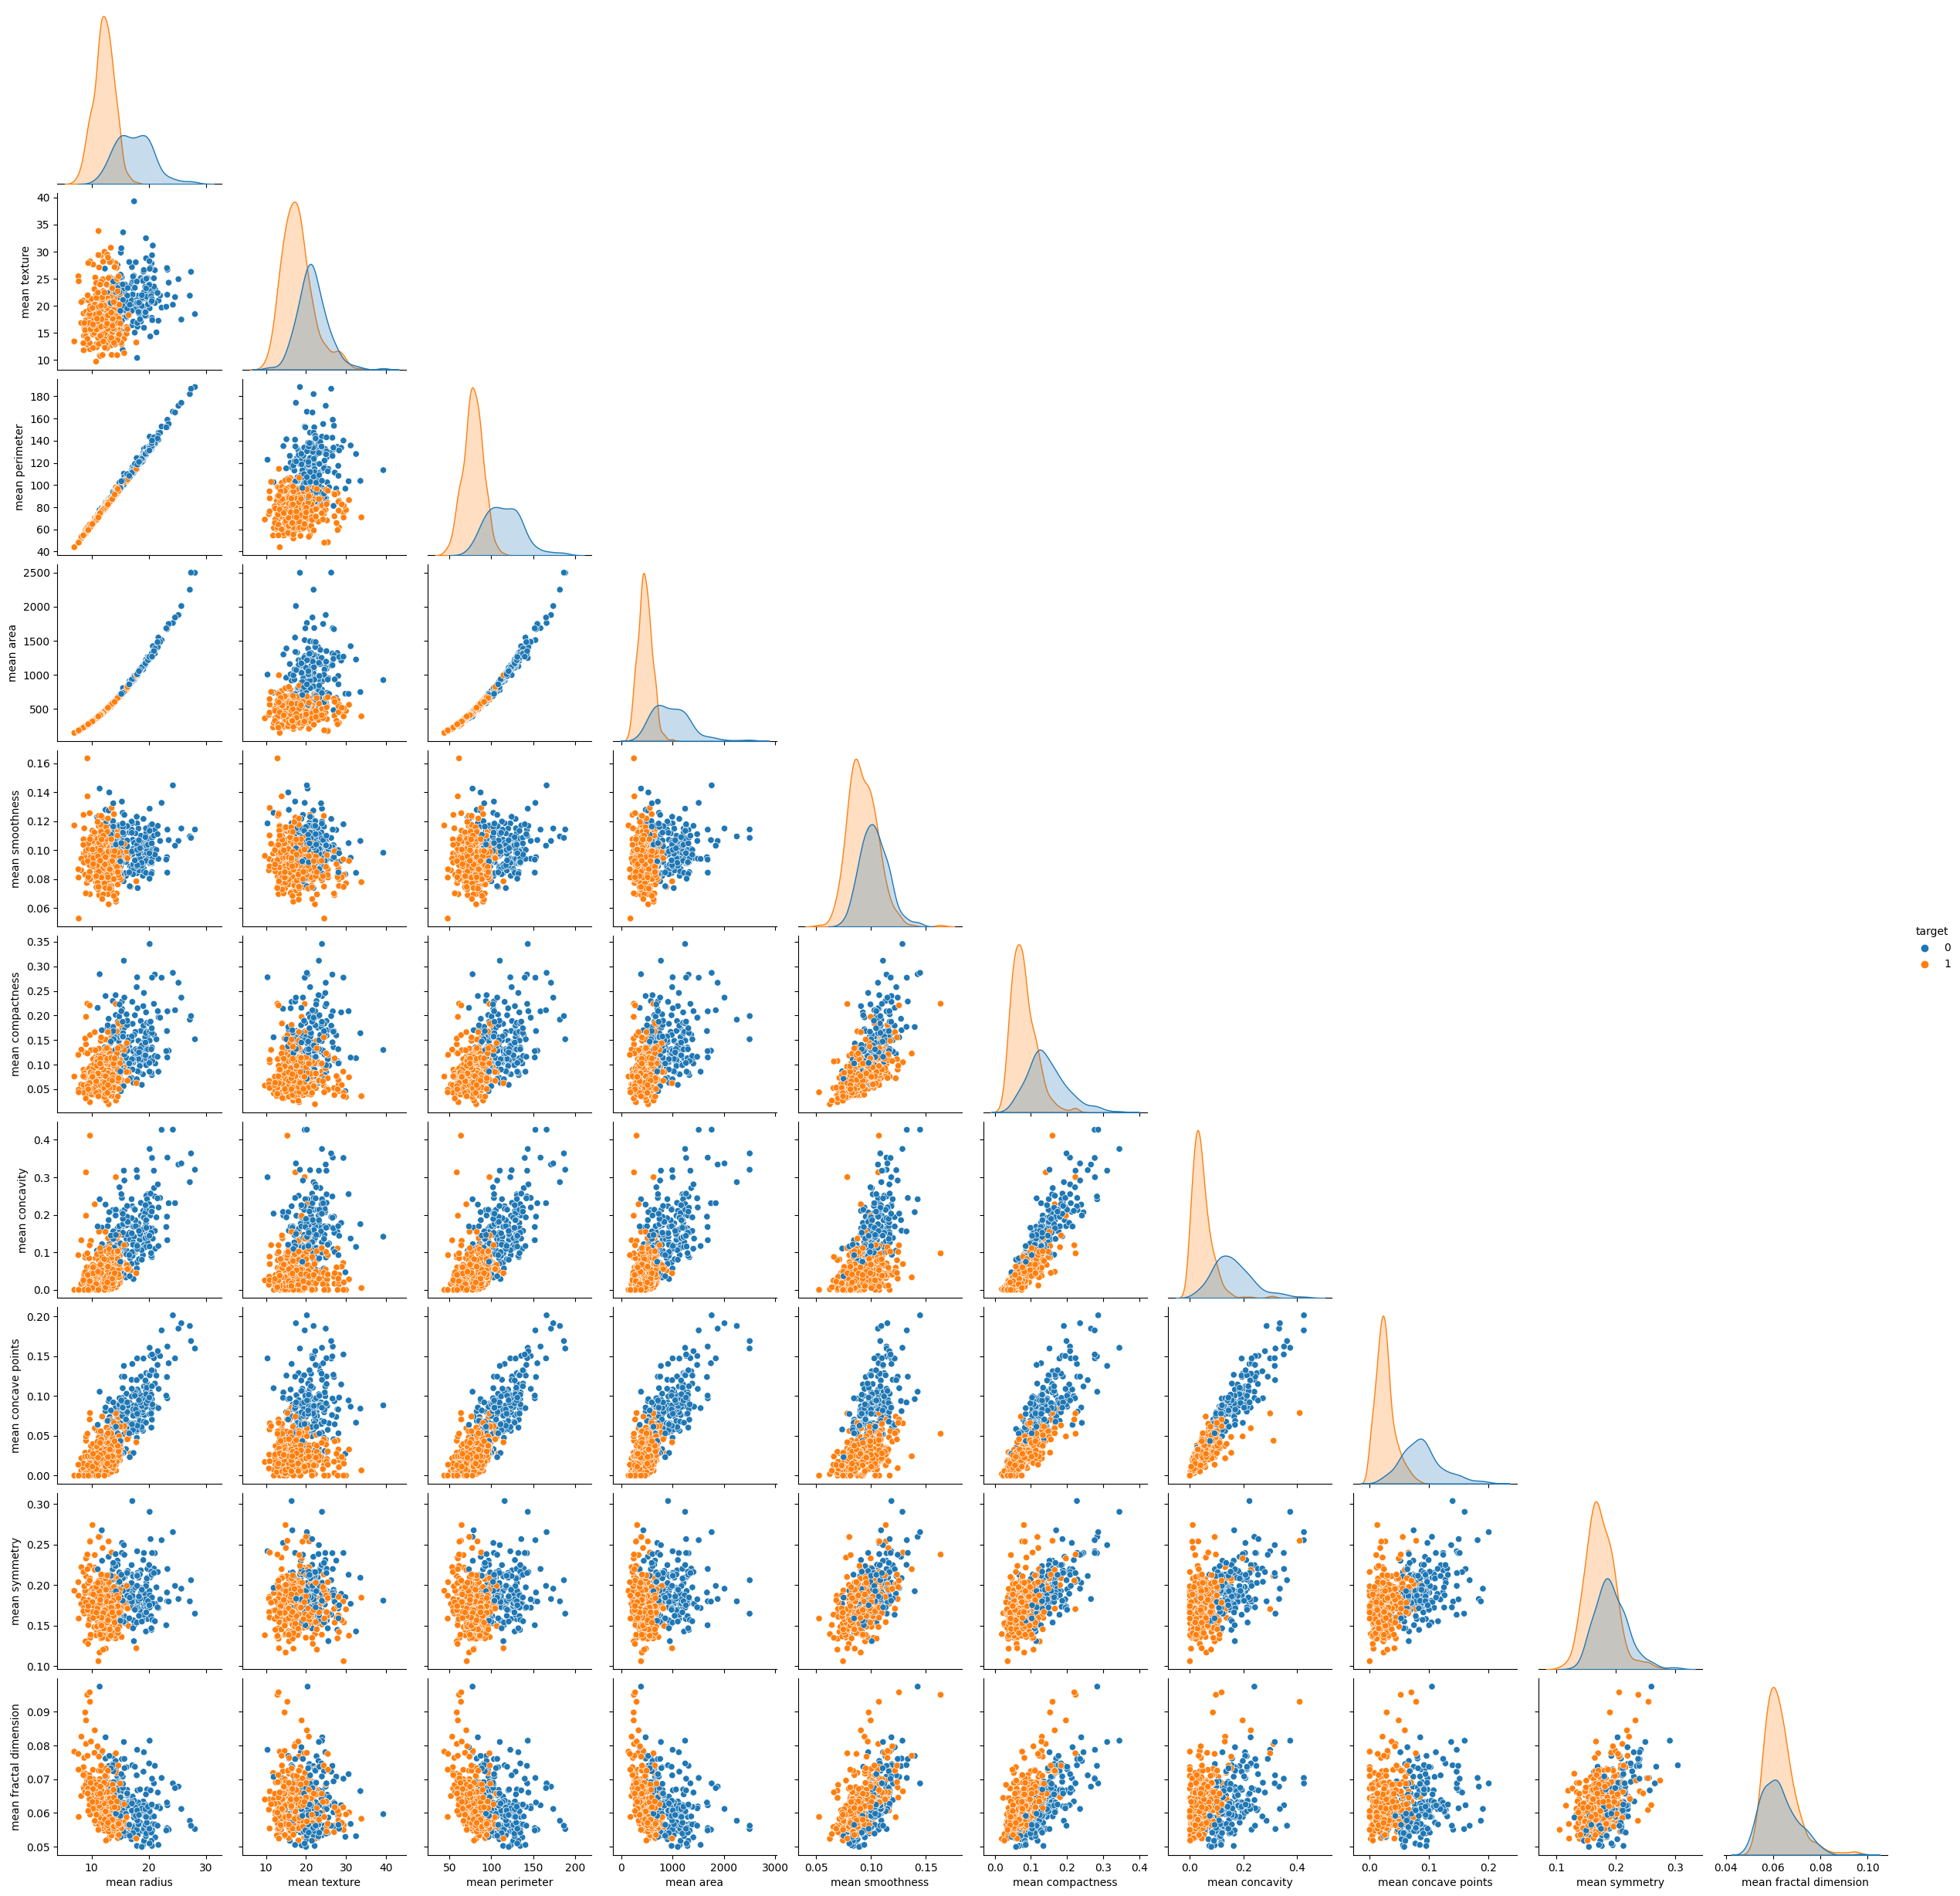

In [258]:
data10 = pd.concat([bc_X.iloc[:,0:10], bc_y], axis=1)
sns.pairplot(data10, diag_kind = 'kde', hue='target',corner=True)

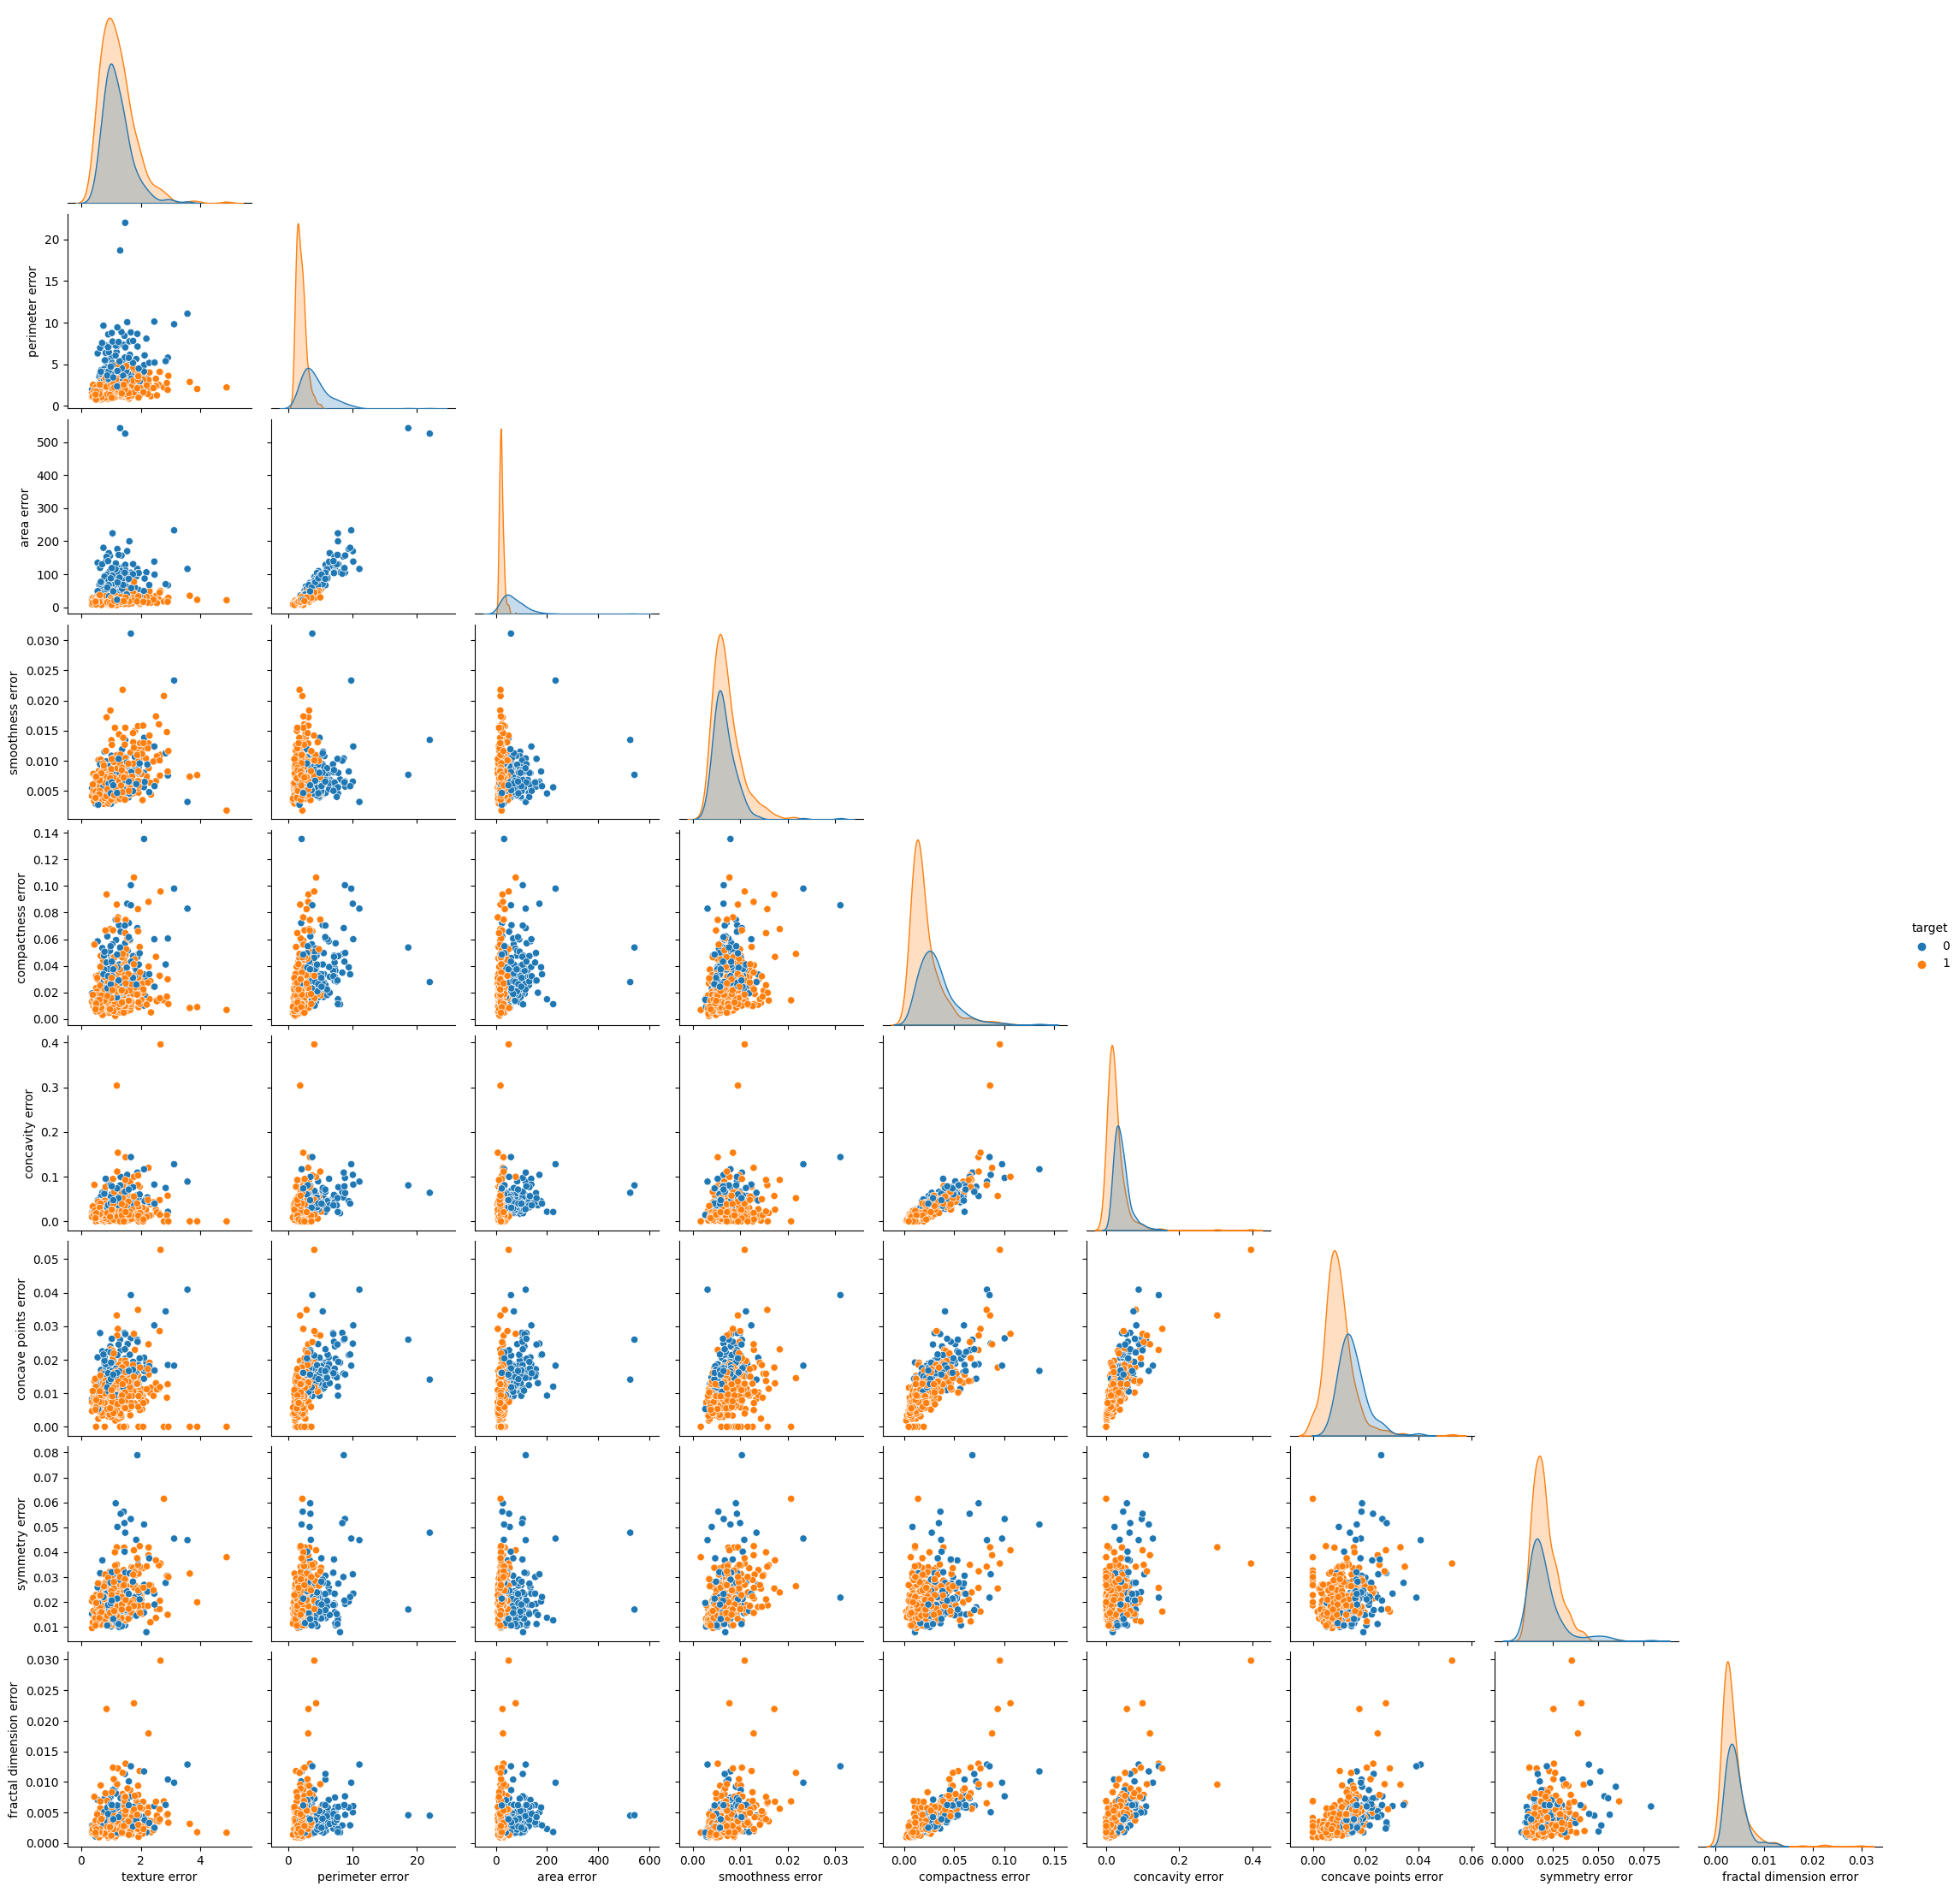

In [67]:
data20 = pd.concat([bc_X.iloc[:,11:20], bc_y], axis=1)
sns.pairplot(data20, diag_kind = 'kde', hue='target',corner=True)

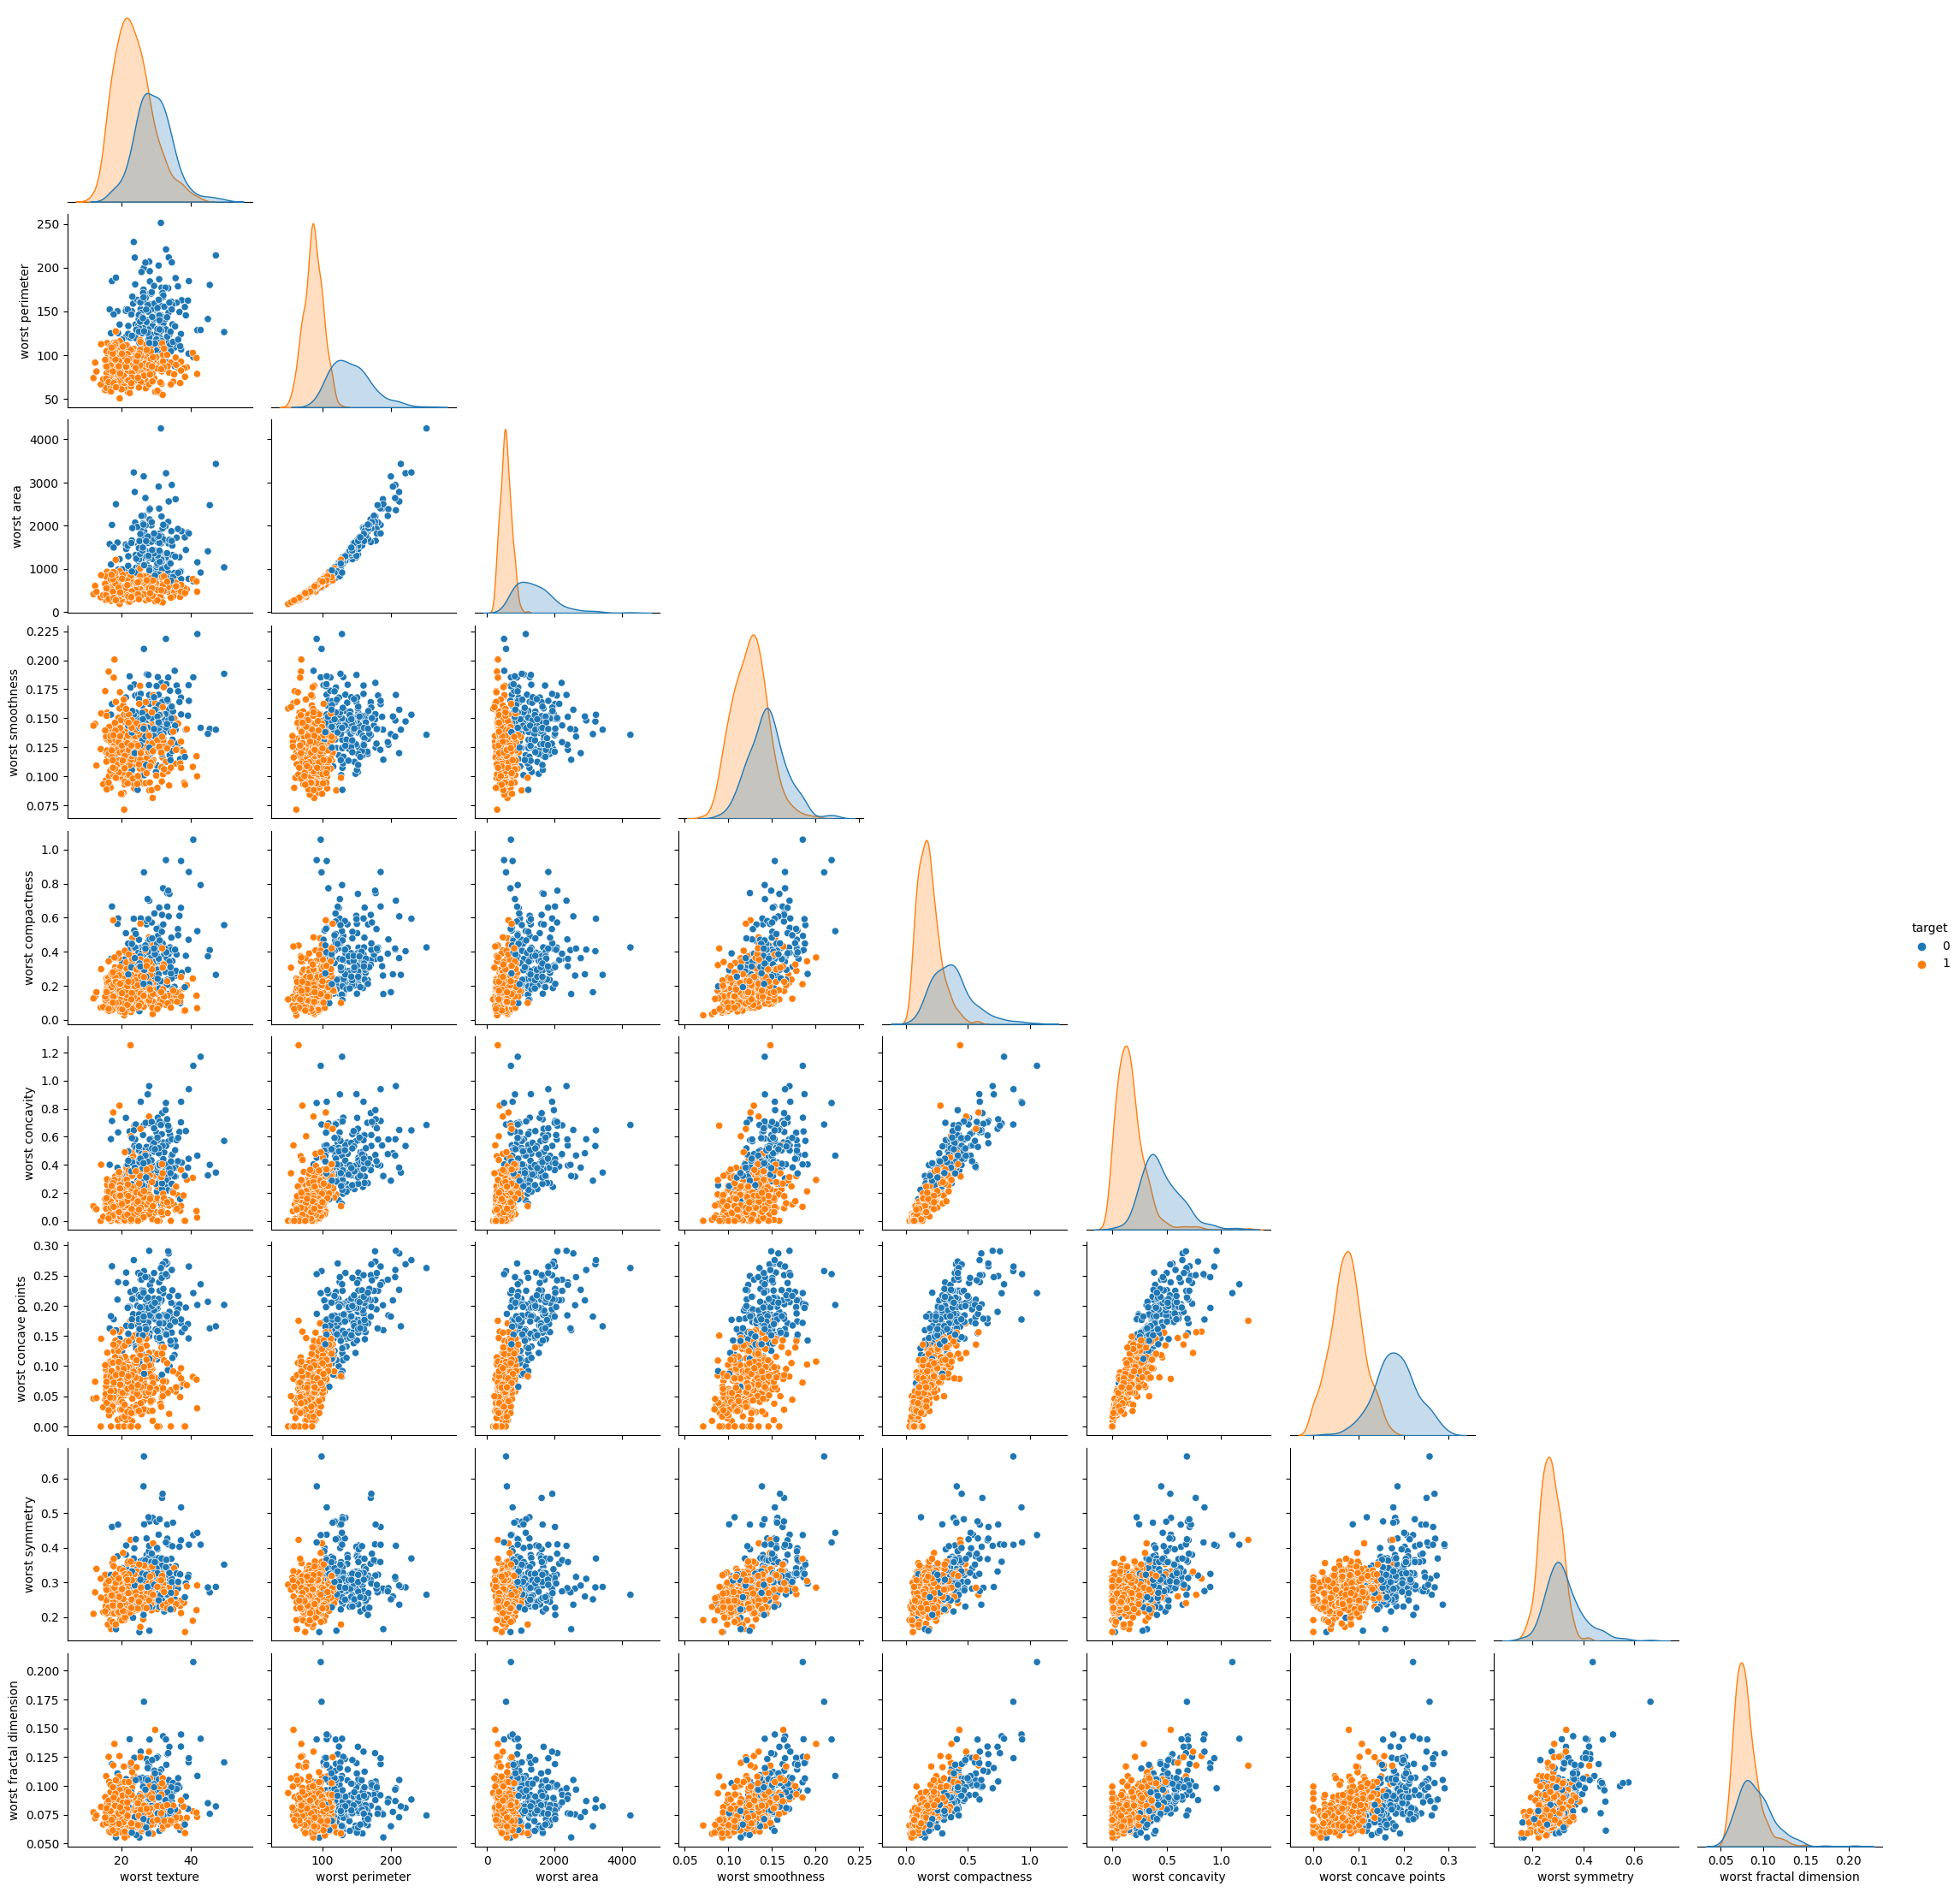

In [68]:
data30 = pd.concat([bc_X.iloc[:,21:30], bc_y], axis=1)
sns.pairplot(data30, diag_kind = 'kde', hue='target',corner=True)

Upon looking at the scatterplot of the first 10 covariates, followed by the next 10 and the last 10, we observe that there are some pairs show a clear linear relationship and also a clear seperation of the classes (target 0 and 1).

From the visualisation, because we have a quite large number of covariates, perhaps it would be better if we use some correlation score to help us identify the pairs of covariates that are highly correlated to each other, given a threshold score of 0.9. 

In [176]:
def correlation_pairs(data_X, threshold=0.85):
    corrmatrix = data_X.corr().abs() # get correlation matrix
    np.fill_diagonal(corrmatrix.values, 0) # remove the diag 1s
    
    # retrive highly correlated pairs
    corrpairs = []
    for pair1 in bc10.columns:
        for pair2 in bc10.columns:
            if corrmatrix.loc[pair1,pair2] > threshold:
                corrpairs.append((pair1,pair2))
                
    drop_features = []
    for f1, f2 in corrpairs:
        if f1 not in drop_features and f2 not in drop_features:
            drop_features.append(f2)
    return drop_features

In [156]:
redundant_features = correlation_pairs(bc_X)

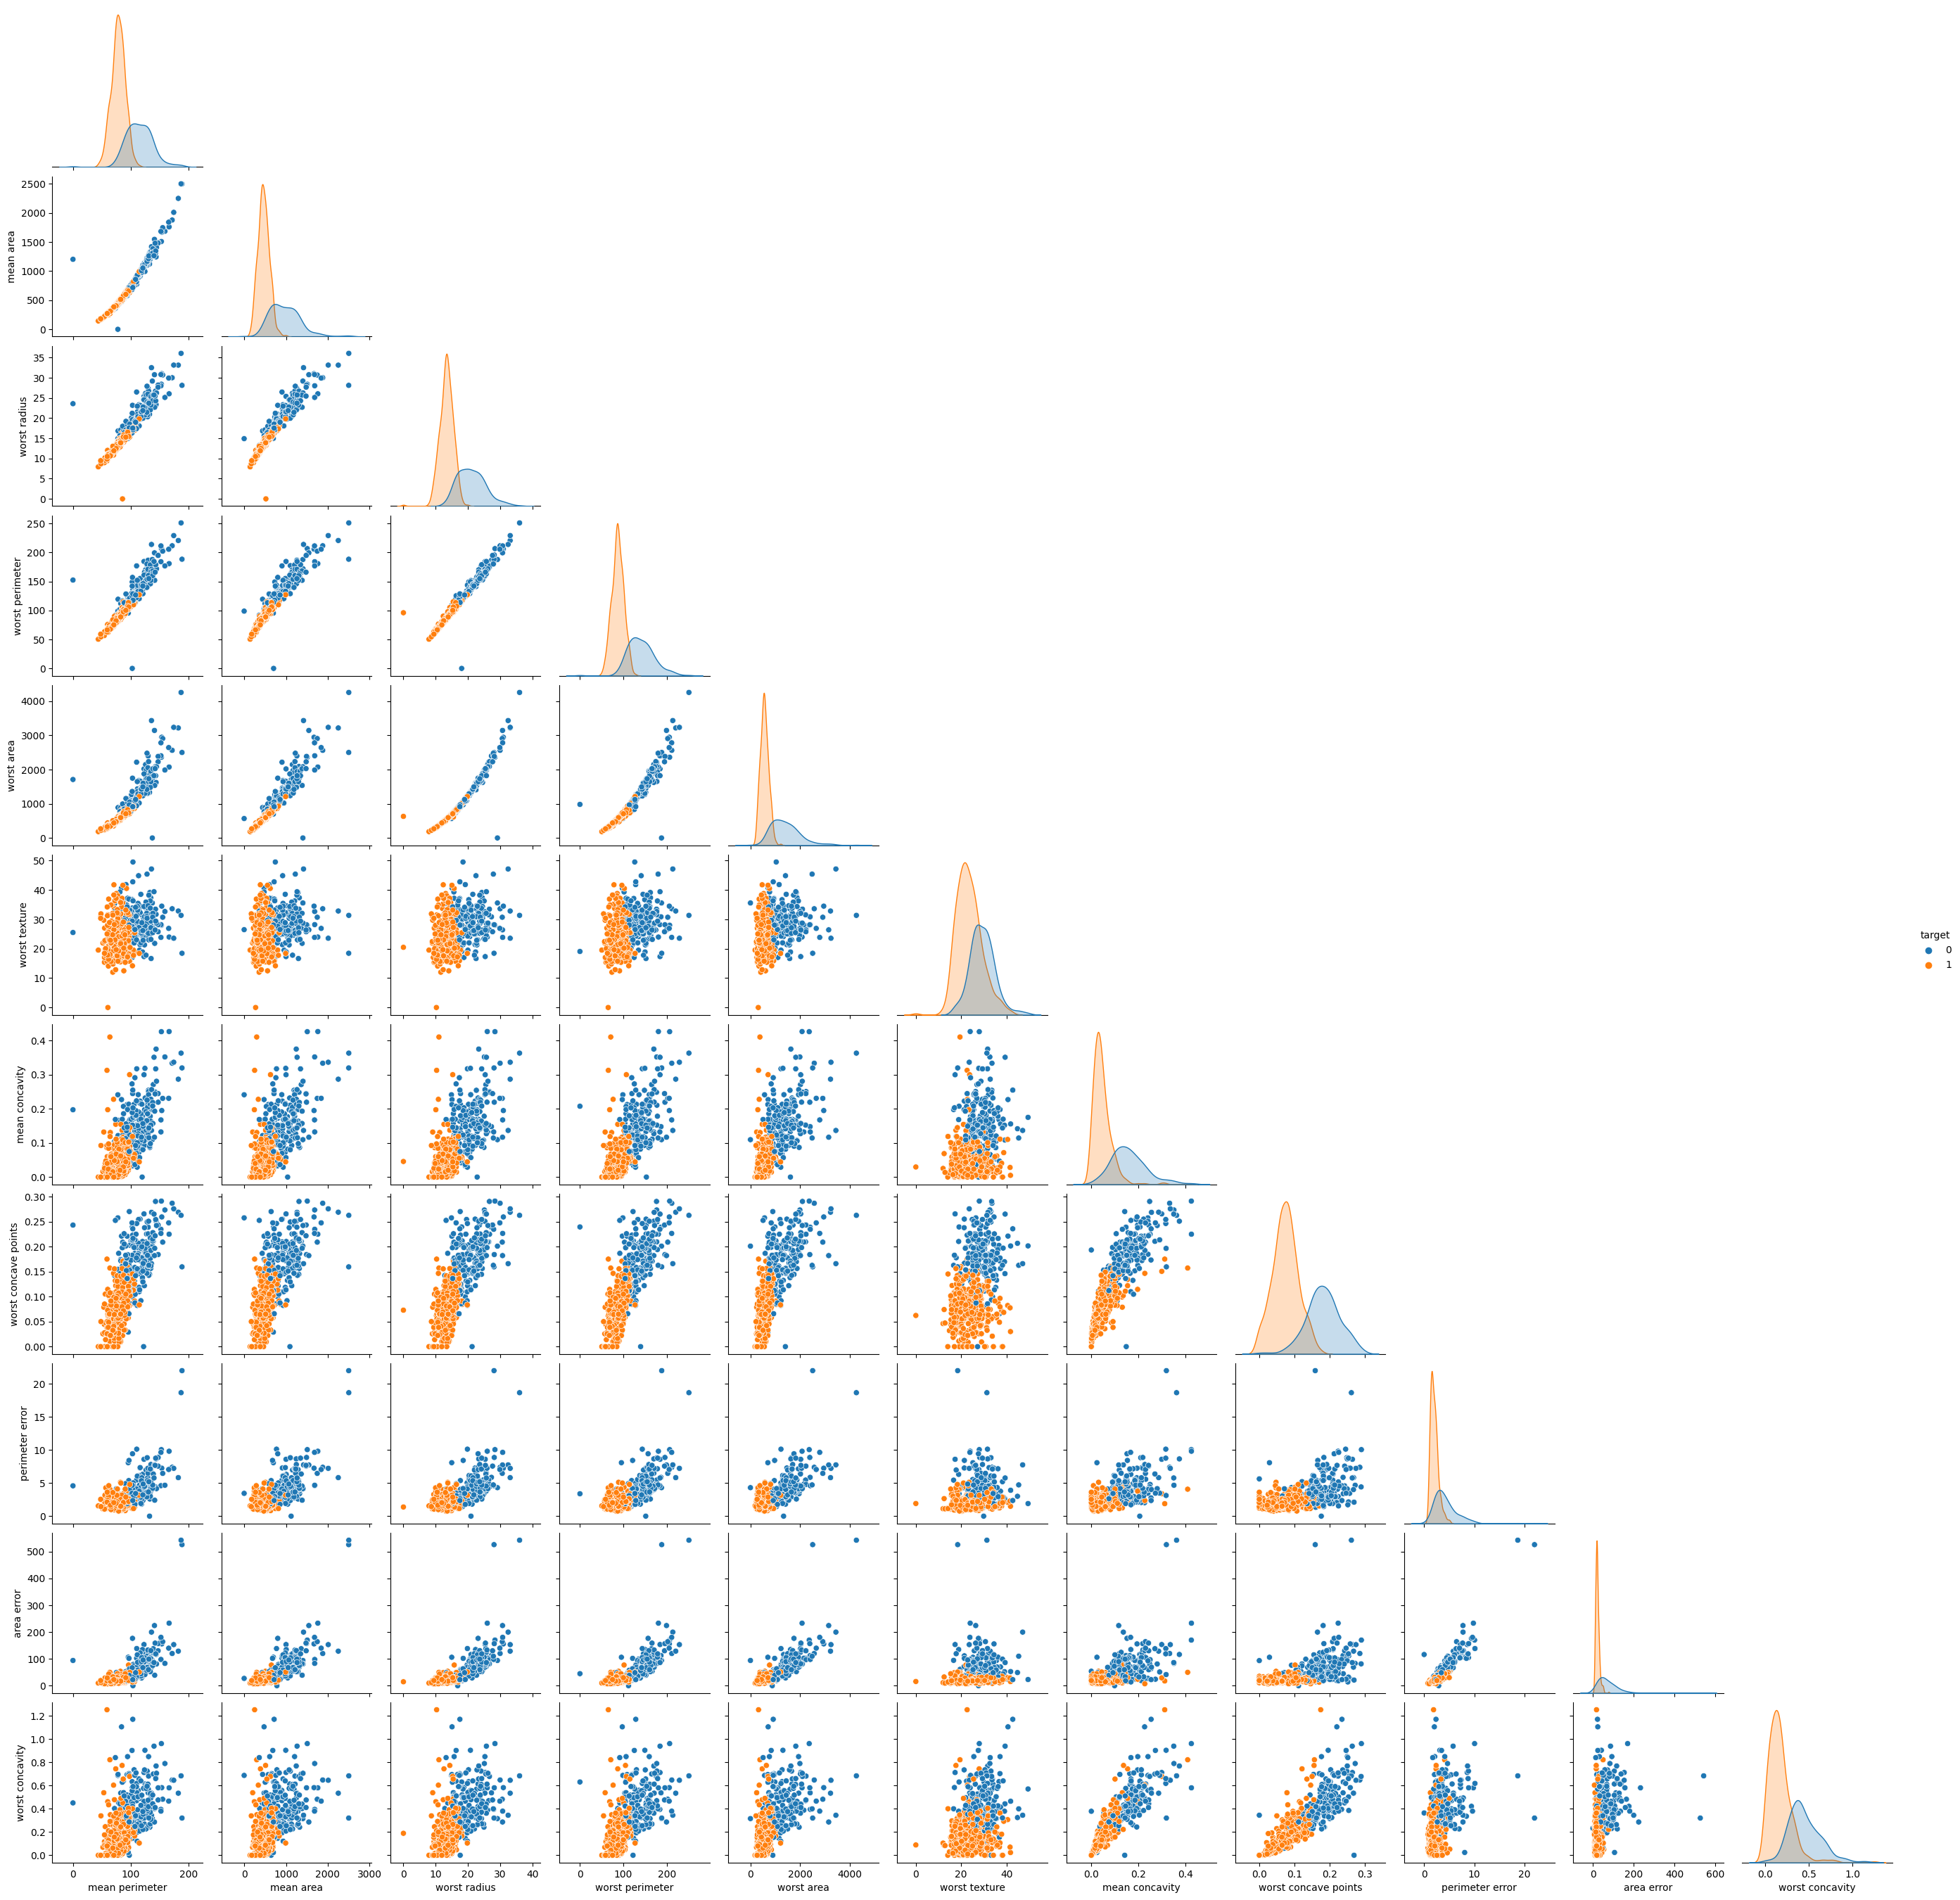

In [159]:
data_rf = pd.concat([bc_X.loc[:,redundant_features], bc_y], axis=1)
sns.pairplot(data_rf, diag_kind = 'kde', hue='target',corner=True)

As expected, we see the pairs plot of the features that we identified to be correlated to one another with good class seperation, so we can remove all of them except 1, which will be mean perimeter.

In [164]:
# keeping the mean perimeter variable and dropping the rest
redundant_features[1:]

['mean area',
 'worst radius',
 'worst perimeter',
 'worst area',
 'worst texture',
 'mean concavity',
 'worst concave points',
 'perimeter error',
 'area error',
 'worst concavity']

In [168]:
bc_X_dropped = bc_X.drop(columns=redundant_features[1:])
bc_X_dropped.shape # we dropped 10 variables

(569, 20)

We can then now proceed to split the training and the test set into a 85/15 ratio.

In [177]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into train and test
train_X, test_X, train_Y, test_Y = train_test_split(bc_X_dropped, bc_y, test_size = 0.15, random_state=123)
train_X.shape, test_X.shape, train_Y.shape, test_Y.shape

((483, 20), (86, 20), (483,), (86,))

<b>Decision Tree Classifiers</b>

1. Train a Decision Tree Classifier using all the default values for all the hyperparameters

In [179]:
from sklearn.tree import DecisionTreeClassifier

In [189]:
# default values for all the hyperparams
tree_clf_first = DecisionTreeClassifier(random_state=123)
tree_clf_first.fit(train_X.values, train_Y)

DecisionTreeClassifier(random_state=123)

We then use the model, with all default hyperparameters to perform predictions on the training set and the test set.

In [270]:
from sklearn.metrics import accuracy_score

# create a function to calculate the accuracy score
def calculate_accuracy(model, dataset, actual):
    pred = model.predict(dataset.values)
    train_score = accuracy_score(actual, pred)
    return(train_score)

def train_test_acc(model, train_X, trainY, testX, testY):
    train_acc = calculate_accuracy(model, train_X, trainY)
    test_acc = calculate_accuracy(model, testX, testY)
    print('Training accuracy: {}'.format(train_acc))
    print('Test accuracy: {}'.format(test_acc))

train_test_acc(tree_clf_first, train_X, train_Y, test_X, test_Y)

Training accuracy: 1.0
Test accuracy: 0.8837209302325582


Looking at the accuracy score of the model fit, we can see that for the training set, it achieved a perfect score, compared to the test set accuracy, which is about 88%, showing quite a significant difference between the 2 scores. This might be a sign of the decision tree classifier being overfitted, capturing the variation/noise in the data.

Because we used the default hyperparameters, where max_depth is not specified, meaning that the tree could be built all leaves are pure or until all leaves contain less than min_samples_split samples, which is default 2, then there is a good chance we have overfitted the training data, and we want to generalise the model by perhaps pruning it (adjusting the hyperparameter of max_depth to a value, but not underfitting the tree)

In [220]:
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

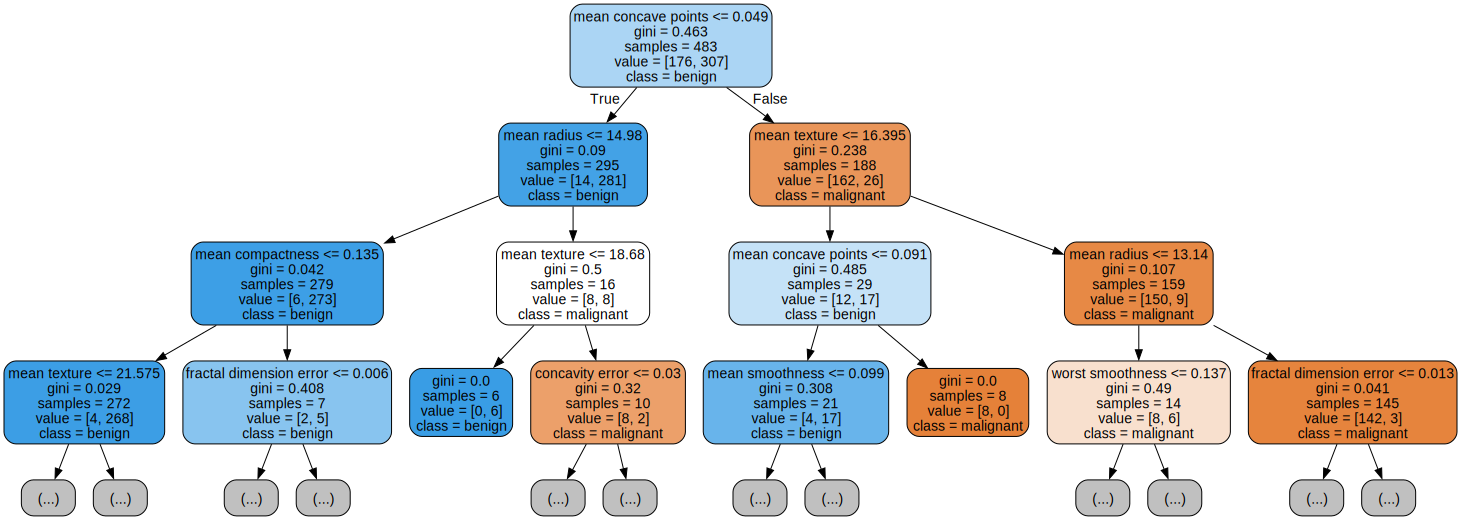

In [266]:
from graphviz import Source
from sklearn.tree import export_graphviz

# Generating a visual on the tree model:
export_graphviz(
        tree_clf_first,
        out_file=os.path.join(IMAGES_PATH, "tree_clf_first.dot"),
        feature_names=train_X.columns,
        class_names=load_breast_cancer().target_names,
        rounded=True,
        filled=True,
        max_depth=3,
    )

Source.from_file(os.path.join(IMAGES_PATH, "tree_clf_first.dot"))

? Study the diagram to see if can help us to confirm that it might be an overfitting issue

In [272]:
# Construct a second DT classifier by setting the hyperparameter to max_depth=3, and calculate the accuracy scores
tree_clf_second = DecisionTreeClassifier(max_depth=3, random_state=123)
tree_clf_second.fit(train_X.values, train_Y)
train_test_acc(tree_clf_second, train_X, train_Y, test_X, test_Y)

Training accuracy: 0.9565217391304348
Test accuracy: 0.8953488372093024


Seems like the test accuracy does slightly better than the default model, 